# Récupération et traitement des données

In [1]:
import re
import urllib
import pandas as pd
import geopandas as gpd
import bs4 

## 1. Récupération des données de la mairie de Paris concernant l'encadrement des loyers

La mairie de Paris a mis en ligne une base de données concernant l'encadrement des loyers de ses logements en 2019. On y trouve une classification des logements, selon leur secteur de localisation (quartier administratif) et leur type (nombre de pièces, époque de construction, ...), accompagnée de leurs loyers de référence. 

Lien contenant les informations sur ces données : https://opendata.paris.fr/explore/dataset/logement-encadrement-des-loyers/information/?disjunctive.id_zone&disjunctive.nom_quartier&disjunctive.piece&disjunctive.epoque&disjunctive.meuble_txt&sort=-id_zone&location=15,48.84958,2.34691&basemap=jawg.streets

In [2]:
donnees_brutes = gpd.read_file('https://opendata.paris.fr/explore/dataset/logement-encadrement-des-loyers/download/?format=geojson&timezone=Europe/Berlin&lang=fr')

In [3]:
donnees_brutes.head(5)

,ville,epoque,meuble_txt,max,min,code_grand_quartier,nom_quartier,id_quartier,piece,ref,annee,id_zone,geometry
0,PARIS,Avant 1946,meublé,27.24,15.89,7511974,Pont-de-Flandre,74,4,22.7,2020,13,"POLYGON ((2.38488 48.88663, 2.38483 48.88662, ..."
1,PARIS,Avant 1946,meublé,27.84,16.24,7511976,Combat,76,3,23.2,2020,14,"POLYGON ((2.38834 48.88057, 2.38950 48.87955, ..."
2,PARIS,1971-1990,non meublé,27.72,16.17,7511976,Combat,76,1,23.1,2020,14,"POLYGON ((2.38834 48.88057, 2.38950 48.87955, ..."
3,PARIS,Avant 1946,meublé,30.00,17.50,7511973,Villette,73,2,25.0,2020,13,"POLYGON ((2.37050 48.87820, 2.37028 48.87799, ..."
4,PARIS,Apres 1990,non meublé,19.68,11.48,7511975,Amérique,75,4,16.4,2020,13,"POLYGON ((2.40940 48.88019, 2.40995 48.87952, ..."


On peut ne sélectionner que les colonnes qui nous intérèssent : 
- `nom_quartier` et `id_quartier` : nom et id du quartier (administratif)
- `ref` : loyer de référence (encadrement : `min` et `max`)
- `epoque` : époque de construction de l'appartement
- `meuble_txt` : location en tant que logement meublé ou non-meublé
- `piece` : nombre de pièces
- `geometry` : représentation graphique du quartier.

In [5]:
donnees = donnees_brutes[['nom_quartier','id_quartier','ref','min','max','epoque','meuble_txt','piece','geometry']]

In [5]:
donnees.head(5)

,nom_quartier,id_quartier,ref,min,max,epoque,meuble_txt,piece,geometry
0,Plaisance,56,22.5,15.75,27.00,Avant 1946,meublé,4,"POLYGON ((2.32113 48.83990, 2.32137 48.83978, ..."
1,Parc-de-Montsouris,54,21.4,14.98,25.68,1946-1970,meublé,3,"POLYGON ((2.34400 48.81613, 2.34397 48.81577, ..."
2,Saint-Lambert,57,26.6,18.62,31.92,Apres 1990,meublé,3,"POLYGON ((2.30425 48.84041, 2.30497 48.84061, ..."
3,Grenelle,59,24.1,16.87,28.92,Avant 1946,non meublé,2,"POLYGON ((2.30088 48.85118, 2.30088 48.85118, ..."
4,Auteuil,61,27.8,19.46,33.36,Apres 1990,meublé,3,"POLYGON ((2.24922 48.85783, 2.24959 48.85782, ..."


Cette base de données référence 2560 appartements. On constate qu'il n'y a pas de valeurs manquantes :

In [6]:
donnees.count()

nom_quartier    2560
id_quartier     2560
ref             2560
min             2560
max             2560
epoque          2560
meuble_txt      2560
piece           2560
geometry        2560
dtype: int64

## 2. Enrichissement des données : superficie des quartiers et distance au centre de Paris


In [56]:
donnees.crs

{'init': 'epsg:4326'}

On va devoir faire en sorte d'utiliser le système de projection epsg 2154 dans la suite pour pouvoir obtenir des distances en mètre et des aires en mètres carrés.

- On ajoute la distance (du centre du quartier) au centre de Paris (intuition : plus un bien est proche du centre de Paris, plus il est convoité et donc valorisé) :

In [57]:
#Centres des quartiers :

df = donnees.centroid 
df = df.to_crs(epsg=2154)

In [58]:
#Centre de Paris (coordonnées trouvées sur internet): 

longitude = [2.3488 for i in range(2560)]
latitude = [48.8534 for i in range(2560)]

df2 = gpd.GeoDataFrame(geometry = gpd.points_from_xy(longitude, latitude),crs={'init': 'epsg:4326'})
df2 = df2.to_crs(epsg=2154)

In [72]:
distances = pd.DataFrame(df.distance(df2)*10**(-3),columns=["distance_centre_paris"])  #la multiplication par 10^3 convertit les mètres en kms

In [73]:
distances.head(5)

,distance_centre_paris
0,5.379327
1,3.627396
2,3.627396
3,4.249599
4,4.643892


In [74]:
donnees = donnees.join(distances)

In [75]:
donnees.head(5)

,nom_quartier,id_quartier,ref,min,max,epoque,meuble_txt,piece,geometry,superficie_quartier,0,distance_centre_paris
0,Pont-de-Flandre,74,22.7,15.89,27.24,Avant 1946,meublé,4,"POLYGON ((2.38488 48.88663, 2.38483 48.88662, ...",0.000291,5.379327,5.379327
1,Combat,76,23.2,16.24,27.84,Avant 1946,meublé,3,"POLYGON ((2.38834 48.88057, 2.38950 48.87955, ...",0.000159,3.627396,3.627396
2,Combat,76,23.1,16.17,27.72,1971-1990,non meublé,1,"POLYGON ((2.38834 48.88057, 2.38950 48.87955, ...",0.000159,3.627396,3.627396
3,Villette,73,25.0,17.50,30.00,Avant 1946,meublé,2,"POLYGON ((2.37050 48.87820, 2.37028 48.87799, ...",0.000158,4.249599,4.249599
4,Amérique,75,16.4,11.48,19.68,Apres 1990,non meublé,4,"POLYGON ((2.40940 48.88019, 2.40995 48.87952, ...",0.000225,4.643892,4.643892


- On ajoute la superficie de chaque quartier (intuition : plus un quartier est petit plus l'offre de logements est restreinte et les biens sont valorisés) :

In [77]:
df3 = donnees.geometry
df3 = df3.to_crs(epsg=2154)

In [83]:
donnees['superficie_quartier'] = df3.area.div(10**6)  #La division convertit les m² en km²

In [84]:
donnees.head(5)

,nom_quartier,id_quartier,ref,min,max,epoque,meuble_txt,piece,geometry,superficie_quartier,0,distance_centre_paris,superficie2_quartier
0,Pont-de-Flandre,74,22.7,15.89,27.24,Avant 1946,meublé,4,"POLYGON ((2.38488 48.88663, 2.38483 48.88662, ...",2.376238,5.379327,5.379327,2.376238
1,Combat,76,23.2,16.24,27.84,Avant 1946,meublé,3,"POLYGON ((2.38834 48.88057, 2.38950 48.87955, ...",1.294988,3.627396,3.627396,1.294988
2,Combat,76,23.1,16.17,27.72,1971-1990,non meublé,1,"POLYGON ((2.38834 48.88057, 2.38950 48.87955, ...",1.294988,3.627396,3.627396,1.294988
3,Villette,73,25.0,17.50,30.00,Avant 1946,meublé,2,"POLYGON ((2.37050 48.87820, 2.37028 48.87799, ...",1.285705,4.249599,4.249599,1.285705
4,Amérique,75,16.4,11.48,19.68,Apres 1990,non meublé,4,"POLYGON ((2.40940 48.88019, 2.40995 48.87952, ...",1.835720,4.643892,4.643892,1.835720


## 3. Enrichissement des données : stations de métro et de rer

Pour enrichir ces données et mieux comprendre l'effet du quartier sur le loyer d'un logement, on peut essayer de compter le nombre de lignes de métro et de rer qui passe dans chaque quartier.  

Pour cela, on va récupérer les données de Wikipédia par web-scraping. On crée une base de données qui recense le nom, la position et le nombre de lignes desservies de chaque station de métro et de rer. 

In [17]:
# Fonction pour transformer les coordonnées récoltées (sous format DMS nord-est) en format DD :

dd = lambda d,m,s : float(d) + float(m)/60 + float(s)/(60*60)
def dms_to_dd (dms):
    parts = re.split('[^\d\w]+', dms)
    lat = dd(parts[0], parts[1], parts[2])
    lng = dd(parts[4], parts[5], parts[6])
    return (lat, lng)

- Pour le métro, on utilise le listing des stations de métro de Wikipédia (https://fr.wikipedia.org/wiki/Liste_des_stations_du_m%C3%A9tro_de_Paris). Pour chaque station de métro, on récupère son nom et on se rend sur sa page Wikipédia pour récupérer ses coordonnées géographiques. Cette station est dupliquée pour chaque ligne de métro qu'elle dessert ;
- Pour le rer, on utilise le listing des stations de rer de Wikipédia (https://fr.wikipedia.org/wiki/Liste_des_gares_du_RER_d%27%C3%8Ele-de-France). On fait le même traitement que pour les métros. Cette fois le listing contient des stations hors Paris, celles de Paris correspondent aux lignes 6 à 34.

In [39]:
nom = []
ligne = [] 
latitude = []
longitude = []

urls = ['https://fr.wikipedia.org/wiki/Liste_des_stations_du_m%C3%A9tro_de_Paris','https://fr.wikipedia.org/wiki/Liste_des_gares_du_RER_d%27%C3%8Ele-de-France']

for url in urls : 

    sock = urllib.request.urlopen(url).read() 
    page=bs4.BeautifulSoup(sock)

    liste_stations = page.find('table').findAll('tr')
    
    for station in liste_stations[1:] :
    
        #Nom de la station :    
        nom_station = station.find('a').text
    
        #Coordonnées géographiques de la station :
        url_station = "http://fr.wikipedia.org"+station.find('a').get('href')
    
        search = urllib.request.urlopen(url_station).read()
        search_station=bs4.BeautifulSoup(search)
    
        coord = search_station.find('a',{'class': "mw-kartographer-maplink"}).text
        lat,lng = dms_to_dd(coord)
    
        #Lignes desservies par la station :    
        lignes = station.find('span',{'style' : "white-space:nowrap"}).findAll('span')
    
        for l in lignes : 
            nom.append(nom_station)
            ligne.append(l.get('data-sort-value'))
            latitude.append(lat)
            longitude.append(lng)
            
stations = gpd.GeoDataFrame(pd.DataFrame({'nom' : nom, 'ligne' : ligne}),geometry=gpd.points_from_xy(longitude, latitude))

In [45]:
stations.head(5)

,nom,ligne,geometry
0,Abbesses,12 !,POINT (2.33861 48.88444)
1,Alésia,04 !,POINT (2.32667 48.82833)
2,Alexandre Dumas,02 !,POINT (2.39500 48.85611)
3,Alma - Marceau,09 !,POINT (2.30028 48.86500)
4,Anatole France,03 !,POINT (2.28556 48.89194)


On récupère ensuite une base de données de la mairie de Paris contenant la liste de ses quartiers administratifs et leur représentation graphique :

In [46]:
quartiers_bruts = gpd.read_file('https://parisdata.opendatasoft.com/explore/dataset/quartier_paris/download/?format=geojson&timezone=Europe/Berlin&lang=fr')
quartiers = quartiers_bruts[['l_qu','c_qu','geometry']]

In [47]:
quartiers.head(5)

,l_qu,c_qu,geometry
0,Sainte-Avoie,12,"POLYGON ((2.35822 48.86122, 2.35690 48.86007, ..."
1,Hôpital-Saint-Louis,40,"POLYGON ((2.37243 48.87611, 2.37359 48.87509, ..."
2,Belleville,77,"POLYGON ((2.38323 48.86710, 2.38314 48.86708, ..."
3,Ternes,65,"POLYGON ((2.29504 48.87378, 2.29504 48.87378, ..."
4,Monnaie,21,"POLYGON ((2.34317 48.85139, 2.34268 48.85036, ..."


On associe ensuite à chaque station le quartier auquel elle appartient :

In [80]:
stations_quartiers = gpd.sjoin(stations, quartiers, op='intersects')


C:\Users\blasc\Anaconda3\lib\site-packages\geopandas\tools\sjoin.py:58: UserWarning: CRS of frames being joined does not match!(None != {'init': 'epsg:4326'})
  warn(


In [81]:
stations_quartiers.head(5)

,nom,ligne,geometry,index_right,l_qu,c_qu
0,Abbesses,12 !,POINT (2.33861 48.88444),48,Clignancourt,70
5,Anvers,02 !,POINT (2.34472 48.88306),48,Clignancourt,70
63,Château Rouge,04 !,POINT (2.34944 48.88667),48,Clignancourt,70
155,Jules Joffrin,12 !,POINT (2.34472 48.89250),48,Clignancourt,70
203,Marcadet - Poissonniers,04 !,POINT (2.35000 48.89028),48,Clignancourt,70


<AxesSubplot:>

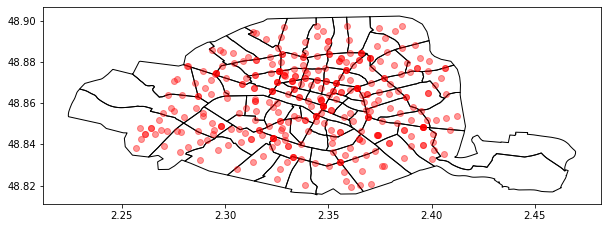

In [87]:
axi = stations_quartiers.plot(figsize = (10,10), color = 'red', alpha = 0.4, zorder=2)
quartiers.plot(ax = axi, zorder=1, edgecolor = "black", facecolor="none",
                                                           color = None)

Il ne reste plus qu'à supprimer les doublons pour savoir quelles lignes de métro ou rer passent dans chaque quartier de Paris. 

In [102]:
lignes_quartiers = stations_quartiers[['c_qu','ligne']].drop_duplicates()

In [118]:
lignes_quartiers.tail(5)

,c_qu,ligne
346,11,08 !
349,7,03 !
361,15,07 !
369,4,01 !
453,19,B !


Ensuite, on réalise un nouveau web scraping sur Wikipédia pour attribuer un score à chaque ligne : on va lister chaque ligne et sa fréquentation annuelle, divisée par la fréquentation annuelle la plus élevée.

In [132]:
#Pour le rer, il faut aller sur chaque page Wikipédia de la ligne. Pour aller plus vite, on le fait manuellement (il n'y a que 5 lignes) :

lignes = ['A !','B !','C !','D !','E !']
frequentation = [309.36,165.5,140,145,60] 


#Pour le métro, il existe directement un classement sur Wikipédia :

sock = urllib.request.urlopen("https://fr.wikipedia.org/wiki/Liste_des_lignes_de_m%C3%A9tro_parisiennes_par_fr%C3%A9quentation").read() 
page=bs4.BeautifulSoup(sock)

liste_lignes = page.find('table').findAll('tr')

for ligne in liste_lignes[1:] :
    
    freq = ligne.find('bdi')
    
    for sous_ligne in ligne.findAll('span') :
        lignes.append(sous_ligne.get('data-sort-value'))
        frequentation.append(float(freq.text.replace(',','.')))
        
lignes_freq = pd.DataFrame({'ligne' : lignes,'fréquentation' : frequentation})

In [133]:
lignes_freq.head(2)

,ligne,fréquentation
0,A !,309.36
1,B !,165.50


In [135]:
lignes_quartiers_freq = lignes_quartiers.merge(lignes_freq, on='ligne')

In [164]:
quartiers_freq = lignes_quartiers_freq[['c_qu','fréquentation']].groupby('c_qu').sum()

m = max(quartiers_freq['fréquentation'])

quartiers_freq['fréquentation'] = quartiers_freq['fréquentation']/m

Pour finir, on ajoute le score obtenu à notre base de données :

In [166]:
donnees_augmentees = donnees.join(quartiers_freq, on='id_quartier')
donnees_augmentees.rename(columns={'fréquentation': 'score_metro'}, inplace=True)

In [167]:
donnees_augmentees.head(5)

,nom_quartier,id_quartier,ref,min,max,epoque,meuble_txt,piece,geometry,superficie_quartier,score_metro
0,Plaisance,56,22.5,15.75,27.00,Avant 1946,meublé,4,"POLYGON ((2.32113 48.83990, 2.32137 48.83978, ...",0.000219,0.127798
1,Parc-de-Montsouris,54,21.4,14.98,25.68,1946-1970,meublé,3,"POLYGON ((2.34400 48.81613, 2.34397 48.81577, ...",0.000166,0.269551
2,Saint-Lambert,57,26.6,18.62,31.92,Apres 1990,meublé,3,"POLYGON ((2.30425 48.84041, 2.30497 48.84061, ...",0.000347,0.080614
3,Grenelle,59,24.1,16.87,28.92,Avant 1946,non meublé,2,"POLYGON ((2.30088 48.85118, 2.30088 48.85118, ...",0.000181,0.390121
4,Auteuil,61,27.8,19.46,33.36,Apres 1990,meublé,3,"POLYGON ((2.24922 48.85783, 2.24959 48.85782, ...",0.000782,0.181809
